In [1]:
import sklearn
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import random
import pandas as pd

In [2]:
# This function both converts images to a blurred, standardized grayscale with standard pixel value between 0 and
# 255

def crop_contour_brain_img(image , plot=False):
    grayscale = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (5,5), 0)
    threshold_image = cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image, None, iterations=2)
    threshold_image = cv2.dilate(threshold_image, None, iterations=2)
    
    contour = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c=max(contour, key=cv2.contourArea)
    
    extreme_pnts_left = tuple(c[c[:,:,0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:,:,0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:,:,1].argmin()][0])
    extreme_pnts_bottom = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extreme_pnts_top[1]:extreme_pnts_bottom[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    return new_image;

In [6]:
from google.colab import drive 
drive.mount('/content/drive') 
import pathlib 
path = pathlib.Path("/content/drive/MyDrive/data") 
%cd /content/drive/MyDrive/data 
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data
 N16.jpg     'no 9.png'                               Y50.JPG   yes/
 no/          xgb-random-grid-search-results-01.csv   Y52.jpg
'no 99.jpg'   Y117.JPG                                Y91.jpg


In [7]:
DATADIR= path
CATEGORIES = ["no", "yes"]

In [8]:
training_data=[]
IMG_SIZE = 250
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array = crop_contour_brain_img(img_array, True)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except:
                print(img)
                pass
            
create_training_data()

In [9]:
random.shuffle(training_data)
print(len(training_data))

246


In [10]:
x=[]
y=[]

In [11]:
for features, label in training_data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(len(x))
print(len(y))

246
246


In [12]:
np.unique(y)

array([0, 1])

In [13]:
x = np.array(x)
y= np.array(y)

In [14]:
x = x.reshape(len(x),-1)

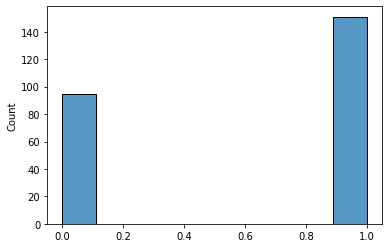

In [15]:
sns.histplot(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42 ,stratify =y )

In [19]:
pca = PCA(n_components=0.98)
X_train = pca.fit_transform(X_train)
n_features=pca.n_components_

n_features

142

In [20]:
X_test = pca.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier , Perceptron
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import confusion_matrix , accuracy_score ,classification_report
from sklearn.metrics import  roc_curve,top_k_accuracy_score ,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
import xgboost as xgb
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

In [24]:
m1 = 'SVC'
svc = make_pipeline(StandardScaler(), SVC(kernel='poly',probability=True))
svc_gridSearch = GridSearchCV(svc, param_grid={'svc__gamma': [ 0.01, 0.1, 1], 
                                                'svc__C': [0.1, 1]}, scoring='precision')

svc_gridSearch.fit(X_train, y_train)
svc_predicted = svc_gridSearch.predict(X_test)

print("confussion matrix")
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
print(svc_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, svc_predicted),2) )
# print("score")
# print(round(svc_gridSearch.score(y_test, svc_predicted),2) )

confussion matrix
[[19  0]
 [23  8]]


precision_score
1.0


In [25]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)

print("confussion matrix")
nbpred_conf_matrix = confusion_matrix(y_test, nbpred)
print(nbpred_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, nbpred),2) )

confussion matrix
[[15  4]
 [ 9 22]]


precision_score
0.85


In [26]:
m3 = 'K-NeighborsClassifier'
knn =Pipeline(steps=[('scaler', StandardScaler()),('knn', KNeighborsClassifier(n_neighbors=3))])

grid_search=knn.fit(X_train,y_train)
knn_predicted = grid_search.predict(X_test)


print("confussion matrix")
knn_predicted_conf_matrix = confusion_matrix(y_test, knn_predicted)
print(knn_predicted_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, knn_predicted),2) )

confussion matrix
[[19  0]
 [28  3]]


precision_score
1.0


In [27]:
m4 = 'Logistic Regression'
log = GridSearchCV(make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
                    param_grid={'logisticregression__C': [0.1, 10,100,500]},
                    cv=2)
log.fit(X_train, y_train)
log_predict = log.predict(X_test)

print("confussion matrix")
log_conf_matrix = confusion_matrix(y_test, log_predict)
print(log_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, log_predict),2) )

confussion matrix
[[11  8]
 [ 9 22]]


precision_score
0.73


In [28]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grids = dict()
grids['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
search = GridSearchCV(Perceptron(), grids, scoring='accuracy', cv=cv, n_jobs=-1)
search.fit(X_train, y_train)
y_predict_perceptron = search.predict(X_test)

print("confussion matrix")
Perceptron_predicted_conf_matrix = confusion_matrix(y_test, y_predict_perceptron)
print(Perceptron_predicted_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, y_predict_perceptron),2) )

confussion matrix
[[11  8]
 [10 21]]


precision_score
0.72


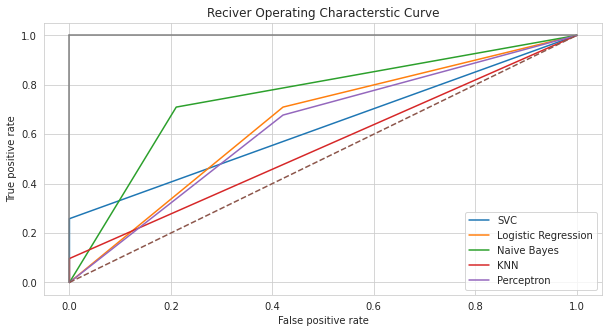

In [29]:
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,log_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)                             
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
perc_false_positive_rate,perc_true_positive_rate,perc_threshold = roc_curve(y_test,y_predict_perceptron)
#stack_false_positive_rate,stack_true_positive_rate,stack_threshold = roc_curve(y_test,y_predict_stacking)

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='SVC')
plt.plot(log_false_positive_rate,log_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='KNN')
plt.plot(perc_false_positive_rate,perc_true_positive_rate,label='Perceptron')
#plt.plot(stack_false_positive_rate,stack_true_positive_rate,label='Stacking')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [30]:
model = XGBClassifier(class_weight='balanced')
model.fit(X_train, y_train)
model_predict = model.predict(X_test)

print("confussion matrix")
model_conf_matrix = confusion_matrix(y_test, log_predict)
print(model_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, log_predict),2) )

confussion matrix
[[11  8]
 [ 9 22]]


precision_score
0.73


In [31]:
params = {
        'min_child_weight': [0,0.01,0.1,0.2],
        'gamma': [0.0001,0.001,0.01,0.1,0.5,0.7],
        'subsample': [0.001,0.01,0.1,0.5,0.7],
        'colsample_bytree': [0.1,0.3,0.6, 0.8, 1.0],
        'max_depth': [5,10,15,20,25,30]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=20, silent=True, nthread=1, class_weight='balanced')

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fed13697ba0>,
                   estimator=XGBClassifier(class_weight='balanced',
                                           learning_rate=0.02, n_estimators=20,
                                           nthread=1, silent=True),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5,
                                                  0.7],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [0, 0.01, 0.1, 0.2],
                                        'subsample': [0.001, 0.01, 0.1, 0.5,
                                                      0.7]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [32]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([0.04428291, 0.10040053, 0.0397803 , 0.02106746, 0.08334819]), 'std_fit_time': array([0.01929446, 0.00460595, 0.00375646, 0.00098674, 0.01907835]), 'mean_score_time': array([0.00370542, 0.00285244, 0.00183431, 0.00288407, 0.00177272]), 'std_score_time': array([2.56980466e-03, 1.56939056e-03, 9.91856313e-05, 1.68367109e-03,
       6.72214502e-05]), 'param_subsample': masked_array(data=[0.001, 0.5, 0.5, 0.01, 0.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[0.01, 0.1, 0.1, 0.01, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[15, 20, 5, 15, 30],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.0001, 0.0001, 0.5, 0.01, 0.7],
             mask=[False, False

In [34]:
model = XGBClassifier(subsample=0.5,min_child_weight=0.1 , max_depth=20 ,gamma=0.0001,colsample_bytree=1  )
model.fit(X_train, y_train)
model_predict = model.predict(X_test)

# model_predict = np.where(model_predict > 0.5, 1, 0)

print("confussion matrix")
model_conf_matrix = confusion_matrix(y_test, model_predict)
print(model_conf_matrix)

print("\n")

print("precision_score")
print(round(precision_score(y_test, model_predict),2) )

confussion matrix
[[11  8]
 [ 6 25]]


precision_score
0.76


In [35]:
from sklearn.ensemble import VotingClassifier
estimators=[('model',model) , ('knn',log)]
ensemble = VotingClassifier(estimators, voting='hard')

In [36]:
ensemble.fit(X_train, y_train)
ensemble.score(X_test, y_test)

0.66

In [37]:
model_predict = ensemble.predict(X_test)
# model_predict = np.where(model_predict > 0.5, 1, 0)
model_conf_matrix = confusion_matrix(y_test, model_predict)
model_conf_matrix

array([[13,  6],
       [11, 20]])

In [38]:
print(round(precision_score(y_test, model_predict),2) )

0.77


انتظار میرفت ایکس جی بوکس عملکرد بهتری داشته باشه ولی خوب نشد یا من بلد نبودم. و خیلی عجیبه که با تیون کردن بدتر میشه . چون مسپله تشخیص تومور هست و اگه به موقع تشخیص داده نشه خظرناک میشه  پرسیشن مهم هست که در اس وی سی و کی ان ان ۱۰۰ هست